# Intro to GeoSpatial Analysis in Python
## w/ GeoPandas and PySAL

#### June 20, 2018

#### Simon Kassel | skassel@azavea.com
***

Objective: Demo a few spatial analysis tasks using Airbnb data from London <br>
Outline
    1. GeoDataFrames
        - Reading from geojson
        - Reprojecting
        - Creating point GeoDataFrames from Pandas DataFrames
        - Mapping
    2. Spatial Joins
        - Joining points to polygons
        - Aggregating to polygon-level
    3. Predicting with spatial lags
        - Creating spatial weights matrices
        - Generating spatial lag variables
        - Using spatial lag in a predictive model
        
Download this notebook and data from https://github.com/simonkassel/python-geospatial-demo

***

In [219]:
import pysal
import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline  

Data source: http://tomslee.net/airbnb-data (Airbnb data), https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london (London boroughs shapefile)

### 1) GeoDataFrames

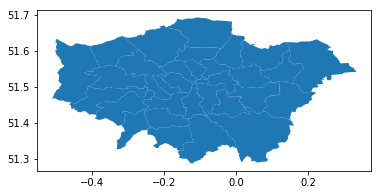

In [174]:
# read in borough shapefile and reproject
boroughs = gpd.read_file('london_boroughs.geojson')
boroughs = boroughs.to_crs(crs={'init': 'epsg:4326'})
boroughs.plot()

In [107]:
# read in airbnb data as a csv
airbnb = pd.read_csv('tomslee_airbnb_london_1486_2017-07-28.csv')

In [108]:
# constructing a GeoDataFrame from pandas data frame
type(boroughs.geometry[0])

shapely.geometry.polygon.Polygon

In [109]:
geometry = [Point(xy) for xy in zip(airbnb.longitude, airbnb.latitude)]
geometry[:5]

In [110]:
airbnb_gdf = gpd.GeoDataFrame(airbnb, crs = {'init': 'epsg:4326'}, geometry=geometry)

In [111]:
airbnb_gdf.head()

,room_id,survey_id,host_id,room_type,country,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,last_modified,latitude,longitude,location,geometry
0,5600143,1486,29034308,Shared room,NaN,London,Kensington and Chelsea,Colville,31,5.0,6,1.0,NaN,188.0,NaN,2017-08-04 15:24:33.709081,51.520597,-0.204406,0101000020E61000002D978DCEF929CABFA7B228ECA2C2...,POINT (-0.204406 51.520597)
1,1554492,1486,8276861,Shared room,NaN,London,Lewisham,Crofton Park,0,0.0,4,1.0,NaN,147.0,NaN,2017-08-04 15:24:31.700684,51.450372,-0.034617,0101000020E61000008F71C5C551B9A1BF5E8429CAA5B9...,POINT (-0.034617 51.45037199999999)
2,13888163,1486,67609087,Shared room,NaN,London,Wandsworth,Thamesfield,0,0.0,6,1.0,NaN,27.0,NaN,2017-08-04 15:24:15.294433,51.464489,-0.221920,0101000020E610000064062AE3DF67CCBF062D246074BB...,POINT (-0.22192 51.464489)
3,6766422,1486,21241056,Shared room,NaN,London,Lambeth,Stockwell,30,4.0,3,1.0,NaN,118.0,NaN,2017-08-04 15:24:03.859746,51.471578,-0.126562,0101000020E6100000064B75012F33C0BFADC1FBAA5CBC...,POINT (-0.126562 51.471578)
4,16084322,1486,60720653,Shared room,NaN,London,Barnet,Garden Suburb,0,0.0,2,1.0,NaN,68.0,NaN,2017-08-04 15:23:58.070889,51.570683,-0.188879,0101000020E6100000FF59F3E32F2DC8BF0CB1FA230CC9...,POINT (-0.188879 51.570683)


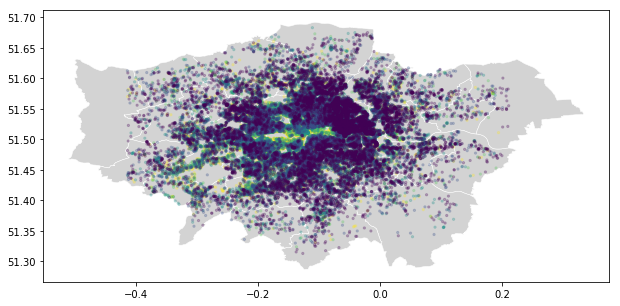

In [114]:
ax = boroughs.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(15,5))
airbnb_gdf.plot(scheme='quantiles', markersize=5, column='price', alpha=0.25, ax=ax)

### 2) Spatial Joins

In [115]:
# first ensure that the two geodataframes have the same projection
boroughs.crs == airbnb_gdf.crs

True

In [116]:
# goal: find the average airbnb price per borough

In [117]:
# a hackey solution using sjoin
boroughs_with_airbnb = gpd.sjoin(boroughs, airbnb_gdf)
boroughs_with_airbnb.shape
prices = boroughs_with_airbnb[['BOROUGH', 'price']].groupby('BOROUGH').mean().reset_index()
geoms = boroughs_with_airbnb[['BOROUGH', 'geometry']].groupby('BOROUGH').first().reset_index()
boroughs_with_avg_prices = pd.merge(prices, geoms)
boroughs_with_avg_prices = gpd.GeoDataFrame(boroughs_with_avg_prices)

In [101]:
boroughs_with_avg_prices.head()

,BOROUGH,price,geometry
0,Barking and Dagenham,67.600000,"POLYGON ((0.165983901625408 51.52879986446649,..."
1,Barnet,94.795474,POLYGON ((-0.183567514704273 51.56800648177927...
2,Bexley,65.168675,"POLYGON ((0.155848856669323 51.43087656341103,..."
3,Brent,103.408107,POLYGON ((-0.220662730845095 51.56167320741739...
4,Bromley,77.324201,"POLYGON ((0.012130938509176 51.29959905965642,..."


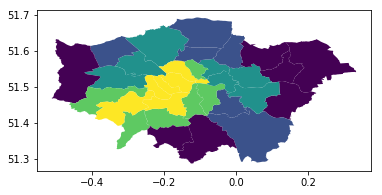

In [102]:
boroughs_with_avg_prices.plot(scheme='quantiles', column='price')

In [104]:
# a more elegant, albeit slower solution using the within method
def calc_avg_price(borough):
    d = airbnb_gdf[airbnb_gdf.within(borough.geometry)]
    return d['price'].mean()

boroughs['avg_price'] = boroughs.apply(calc_avg_price, axis = 1)

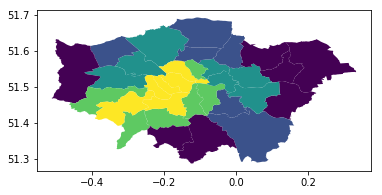

In [105]:
boroughs.plot(scheme='quantiles', column='avg_price')

### 3) Predicting with spatial lags

In [163]:
# subset of all airbnbs (just like working with pandas data frame)
airbnb_gdf = airbnb_gdf[(airbnb_gdf.reviews > 1) & (airbnb_gdf.room_type == 'Entire home/apt')]

In [164]:
# construct spatial weights matrix
w = pysal.weights.KNN.from_dataframe(airbnb_gdf, k=10)

In [165]:
# calculate spatial lag variable
airbnb_gdf['price_lag'] = pysal.lag_spatial(w, airbnb_gdf.price)

In [166]:
# correlation coefficient
np.corrcoef(airbnb_gdf['price'], airbnb_gdf['price_lag'])

array([[1.        , 0.54720686],
       [0.54720686, 1.        ]])

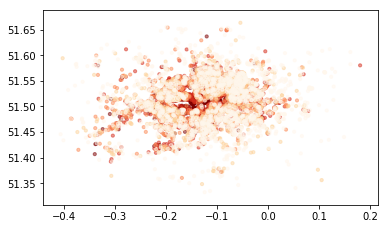

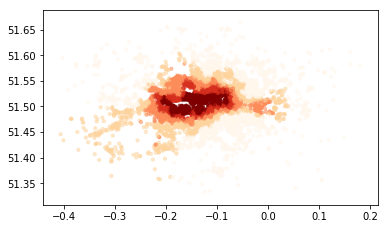

In [208]:
airbnb_gdf.plot(cmap='OrRd', scheme='quantiles', markersize=10, column='price', alpha=0.5)
airbnb_gdf.plot(cmap='OrRd', scheme='quantiles', markersize=10, column='price_lag', alpha=0.5)

In [217]:
def rf_model(gdf, knn):
    """
    Train a random forrest model including a spatial
        lag variable
    
    Args:
        gdf (GeoDataFrame): GeoDataFrame with airbnb rental data
        knn (int): Number of neighbors to use when creating 
            spatial weights matrix
    """
    
    # create spatial lag variable
    w = pysal.weights.KNN.from_dataframe(gdf, k=knn)
    gdf['price_lag'] = pysal.lag_spatial(w, gdf.price)
    
    # labels
    prices = np.array(gdf['price'])
    
    # predictors
    predictors = ['price_lag', 'reviews', 'overall_satisfaction', 'bedrooms', 'neighborhood', 'accommodates']
    predictor_df = gdf[predictors]
    predictor_df = pd.get_dummies(predictor_df) # one-hot encoding
    pred_vars = np.array(predictor_df)
    
    # generate train-test split
    x_train, x_test, y_train, y_test = train_test_split(pred_vars, prices, test_size = 0.25, random_state = 123)
    
    # fit random forrest model
    rf = RandomForestRegressor(random_state=456)
    rf.fit(x_train, y_train)
    
    # predict and calculate MAPE
    predictions = rf.predict(x_test)
    absolute_pct_error = abs(predictions - y_test) / y_test
    mape = np.mean(absolute_pct_error) 
    
    print('{0} neighbors: {1}'.format(knn, mape))
    return (rf, mape, knn)

In [218]:
for i in [1, 5, 10, 25, 50, 100]:
    rf_model(airbnb_gdf, i)

1 neighbors: 0.25502842297709066
5 neighbors: 0.2425927084592575
10 neighbors: 0.24194291308517984
25 neighbors: 0.24005535066460845
50 neighbors: 0.24583006845289493
100 neighbors: 0.2465549114356289


In [132]:
one_br.columns

Index(['room_id', 'survey_id', 'host_id', 'room_type', 'country', 'city',
       'borough', 'neighborhood', 'reviews', 'overall_satisfaction',
       'accommodates', 'bedrooms', 'bathrooms', 'price', 'minstay',
       'last_modified', 'latitude', 'longitude', 'location', 'geometry',
       'price_lag'],
      dtype='object')